In [1]:
# Cell 1: Setup – imports, DM test, lag selection, data loading, VAR endog block

from __future__ import annotations

import math
import warnings
from typing import Dict, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR

warnings.filterwarnings("ignore")


# ----------------------------
# Diebold–Mariano test (Chronos-style, two-sided)
# ----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse",
) -> Tuple[float, float]:
    """
    Diebold–Mariano test for equal predictive accuracy (Chronos-style).

    Parameters
    ----------
    y_true : pd.Series
        Realised values.
    y_model : pd.Series
        Forecasts from the model being evaluated.
    y_rw : pd.Series
        Forecasts from the benchmark model (e.g. random walk).
    h : int, default 1
        Forecast horizon. For non-overlapping horizons, h=1 is appropriate.
        For overlapping horizons, set h equal to the forecast horizon and
        a simple Newey–West/Bartlett HAC up to lag h-1 is used.
    loss : {"mse", "mae"}, default "mse"
        Loss function used to construct the loss differential.

    Returns
    -------
    dm_stat : float
        DM test statistic.
    p_val : float
        Two-sided p-value under asymptotic N(0, 1).
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()

    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]

    if loss.lower() == "mae":
        d = np.abs(e_m) - np.abs(e_r)
    else:  # "mse"
        d = (e_m ** 2) - (e_r ** 2)

    N = int(len(d))
    d_mean = float(d.mean())

    # Variance of loss differential
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N if N > 0 else float("nan")

    # Simple Newey–West / Bartlett HAC if h > 1 (overlapping horizons)
    if h > 1 and N > 2 and np.isfinite(var_bar):
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


# ----------------------------
# Robust VAR lag selection
# ----------------------------
def choose_var_lag(
    train: pd.DataFrame,
    max_p: int,
    prev_p: Optional[int] = None,
) -> int:
    """
    Robustly choose VAR lag order to avoid numerical failures.

    - Restricts max feasible p based on T and k.
    - Tries statsmodels' select_order(AIC).
    - On failure, falls back to a conservative lag length.

    Parameters
    ----------
    train : DataFrame
        Endogenous block used for estimation (T x k).
    max_p : int
        Global upper bound on lag order.
    prev_p : int or None
        Previously used lag (for fallback consistency).

    Returns
    -------
    p : int
        Chosen lag order (>=1).
    """
    T, k = train.shape

    # Conservative feasible upper bound to avoid overparameterization
    p_feasible = max(1, min(max_p, (T - 1) // (k + 1)))
    if p_feasible < 1:
        return 1

    try:
        sel = VAR(train).select_order(maxlags=p_feasible)
        p = sel.selected_orders.get("aic", None)
        if p is None:
            p = prev_p if prev_p is not None else min(2, p_feasible)
    except Exception:
        p = prev_p if prev_p is not None else min(2, p_feasible)

    p = int(p)
    p = max(1, min(p, p_feasible))
    return p


# ----------------------------
# Data loading and endogenous block
# ----------------------------
url = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_monthly.csv"
)

df = pd.read_csv(url)

# Standardise the date index
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
elif "DATE" in df.columns:
    df["Date"] = pd.to_datetime(df["DATE"])
else:
    raise KeyError("Neither 'Date' nor 'DATE' found in column names.")

df = df.sort_values("Date").set_index("Date")

print(f"Data from {df.index.min().date()} to {df.index.max().date()}")
print(f"Total observations: {len(df)}")

# Ensure required columns exist
required_cols = ["EUR_NOK", "d_pi", "dI_t", "Q"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in data: {missing}")

# Build endogenous block
df = df.copy()
df["s"] = np.log(df["EUR_NOK"])  # log spot EUR/NOK

endog_vars = ["s", "d_pi", "dI_t", "Q"]
endog = df[endog_vars].dropna()

dates = endog.index

print("\nEndogenous variables used in VAR:")
print(endog_vars)
print(f"Usable observations after dropna: {len(endog)}")


Data from 2000-01-31 to 2025-11-30
Total observations: 311

Endogenous variables used in VAR:
['s', 'd_pi', 'dI_t', 'Q']
Usable observations after dropna: 311



Quarterly VAR – 1-quarter-ahead (EUR/NOK)
Completed 91 quarterly forecasts.

=== Model performance (quarterly mean, EUR/NOK – VAR) ===
Observations: 91
RMSE (level): 0.303705
MAE  (level): 0.218628
Directional accuracy: 58/90 (64.4%)

=== Diebold–Mariano vs Random Walk (VAR, quarterly) ===
Loss: MSE | horizon h=1
DM-statistic: 0.9851
p-value     : 0.3246


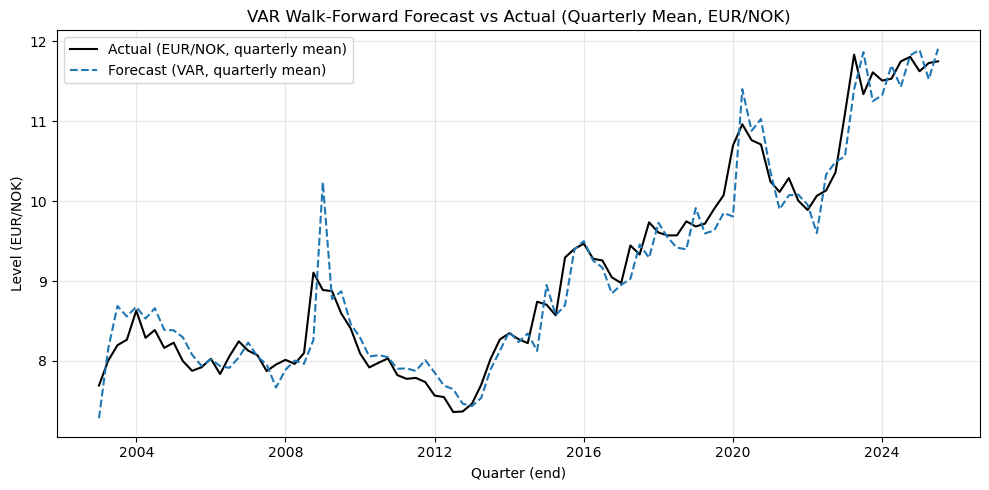


Average selected VAR lag (quarterly origins): 2.00


In [2]:
# Cell 3: Quarterly VAR – 1-quarter-ahead forecast, evaluation, DM vs RW (EUR/NOK)

max_p = 6  # same global max lag
min_train_months = 36

quarter_ends = endog.index[endog.index.is_quarter_end]

rows_q: list[Dict] = []
prev_p_quarterly: Optional[int] = None

for q_idx in range(1, len(quarter_ends)):
    origin = quarter_ends[q_idx - 1]  # last month of quarter t (forecast origin)

    # Ensure enough history
    if origin < dates[min_train_months - 1]:
        continue

    # Target quarter = next three months after origin
    q_start = origin + pd.offsets.MonthEnd(1)
    q_end = origin + pd.offsets.MonthEnd(3)

    if q_end > df.index.max():
        break

    # Expanding window up to origin (monthly)
    train_q = endog.loc[:origin]

    # Robust lag selection
    p_q = choose_var_lag(train_q, max_p=max_p, prev_p=prev_p_quarterly)
    prev_p_quarterly = p_q

    model_q = VAR(train_q).fit(p_q)
    y0_q = train_q.values[-p_q:]

    # 3-step ahead monthly path for [s, d_pi, dI_t, Q]
    f_path = model_q.forecast(y0_q, steps=3)
    path_df = pd.DataFrame(f_path, columns=endog_vars)

    # EUR/NOK: path in levels, quarterly mean
    path_level = np.exp(path_df["s"])
    y_hat_q = float(path_level.mean())

    true_slice = df.loc[q_start:q_end, "EUR_NOK"]
    if len(true_slice) == 0:
        continue
    y_true_q = float(true_slice.mean())

    # Random walk quarterly forecast: flat at last observed monthly level
    last_level = float(np.exp(train_q.loc[origin, "s"]))
    y_rw_q = last_level

    rows_q.append(
        {
            "quarter_end": q_end,
            "origin": origin,
            "y_true_q": y_true_q,
            "y_pred_q": y_hat_q,
            "y_rw_q": y_rw_q,
            "p_used_q": p_q,
        }
    )

df_eval_q = pd.DataFrame(rows_q).set_index("quarter_end").sort_index()

print("\n==============================")
print("Quarterly VAR – 1-quarter-ahead (EUR/NOK)")
print("==============================")
print(f"Completed {len(df_eval_q)} quarterly forecasts.")


# ----- Evaluation (Chronos-style) -----
def evaluate_quarterly_var(df_eval_q: pd.DataFrame) -> pd.DataFrame:
    """
    Compute level errors and directional accuracy for quarterly VAR (EUR/NOK).

    Returns:
      eval_df with columns:
        y_true, y_pred (quarterly mean EUR/NOK levels)
    """
    df = df_eval_q.copy()
    df["err"] = df["y_true_q"] - df["y_pred_q"]
    core = df.dropna(subset=["y_true_q", "y_pred_q"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(core["err"] ** 2))) if n_obs else np.nan
    mae = float(mean_absolute_error(core["y_true_q"], core["y_pred_q"])) if n_obs else np.nan

    # Directional accuracy vs previous quarter
    core["y_prev"] = core["y_true_q"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true_q"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred_q"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (quarterly mean, EUR/NOK – VAR) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    eval_df = core[["y_true_q", "y_pred_q"]].rename(
        columns={"y_true_q": "y_true", "y_pred_q": "y_pred"}
    )
    # Optional: convert index to PeriodIndex for nicer printing, similar to Chronos
    eval_df.index = eval_df.index.to_period("Q")
    return eval_df


def dm_against_random_walk_quarterly(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    """
    DM test vs random walk at quarterly horizon.

    Random walk benchmark: RW_q = y_{q-1}.
    """
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)

    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)

    print("\n=== Diebold–Mariano vs Random Walk (VAR, quarterly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    if np.isfinite(dm_stat):
        print(f"DM-statistic: {dm_stat:.4f}")
    else:
        print("DM-statistic: nan")
    if np.isfinite(p_val):
        print(f"p-value     : {p_val:.4f}")
    else:
        print("p-value     : nan")


# Run evaluation + DM
eval_q = evaluate_quarterly_var(df_eval_q)
dm_against_random_walk_quarterly(eval_q, loss="mse", h=1)

# Optional: plot quarterly actual vs VAR forecast
plt.figure(figsize=(10, 5))
plt.plot(
    df_eval_q.index.to_period("Q").to_timestamp(),
    df_eval_q["y_true_q"],
    label="Actual (EUR/NOK, quarterly mean)",
    color="black",
)
plt.plot(
    df_eval_q.index.to_period("Q").to_timestamp(),
    df_eval_q["y_pred_q"],
    linestyle="--",
    label="Forecast (VAR, quarterly mean)",
)
plt.title("VAR Walk-Forward Forecast vs Actual (Quarterly Mean, EUR/NOK)")
plt.xlabel("Quarter (end)")
plt.ylabel("Level (EUR/NOK)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(
    f"\nAverage selected VAR lag (quarterly origins): "
    f"{df_eval_q['p_used_q'].mean():.2f}"
)
